In [9]:
# --- Task 3: Multimodal ML – Housing Price Prediction ---
# Objective: Predict house prices by fusing structured data (CSV)
# and visual features (Images) using a dual-branch Neural Network.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
# 1. Load the dataset
# Ensure you have uploaded 'Housing.csv' to your Colab session
df = pd.read_csv('Housing.csv')

# 2. Preprocess Binary Columns (Yes/No -> 1/0)
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# 3. One-Hot Encode 'furnishingstatus'
df = pd.get_dummies(df, columns=['furnishingstatus'])

# 4. Separate Features and Target
y = df['price'].values.astype(np.float32)
X_tab = df.drop('price', axis=1).values.astype(np.float32)

print(f"Tabular Data Shape: {X_tab.shape}")
df.head()

Tabular Data Shape: (545, 14)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,True,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,True,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,False,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,True,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,True,False,False


In [11]:
# 1. Scale Tabular Data and Target (0 to 1 range)
scaler_x = MinMaxScaler()
X_tab_scaled = scaler_x.fit_transform(X_tab)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 2. Generate Synthetic Image Data (64x64 pixels, 3 color channels)
# In a real project, you would load your JPG files here.
# --- NEW CODE TO INSERT ---
import cv2

# 1. Function to process your uploaded files
def load_and_resize(path):
    img = cv2.imread(path)
    if img is None:
        print(f"Warning: Could not load {path}")
        return np.zeros((64, 64, 3))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (64, 64)) / 255.0

# 2. Load the 4 images you uploaded
img_luxury = load_and_resize('what-luxury-villas-will-be-ready-in-2025.png')
img_suburban = load_and_resize('Standard Suburban Home.jpg')
img_brick = load_and_resize('Old Brick House.jpg')
img_cottage = load_and_resize('monochromatic-cottage-in-sweden-exterior1-via-smallhousebliss.jpg')

# 3. Create the image array by mapping price to image
prices = df['price'].sort_values()
q1, q2, q3 = prices.quantile([0.25, 0.5, 0.75])

X_img = []
for price in df['price']:
    if price >= q3:
        X_img.append(img_luxury)   # Top 25% prices
    elif price >= q2:
        X_img.append(img_suburban) # 50% - 75%
    elif price >= q1:
        X_img.append(img_brick)    # 25% - 50%
    else:
        X_img.append(img_cottage)  # Bottom 25%

X_img = np.array(X_img).astype(np.float32)

# 3. Split into Train and Test sets
(trainX_tab, testX_tab, trainX_img, testX_img, trainY, testY) = train_test_split(
    X_tab_scaled, X_img, y_scaled, test_size=0.2, random_state=42
)

print("Data preparation and splits complete.")

Data preparation and splits complete.


In [12]:
def build_multimodal_model(tab_shape):
    # Branch A: Tabular Data (MLP)
    tab_inputs = layers.Input(shape=(tab_shape,), name="tabular_input")
    x1 = layers.Dense(16, activation="relu")(tab_inputs)
    x1 = layers.Dense(8, activation="relu")(x1)

    # Branch B: Image Data (CNN)
    img_inputs = layers.Input(shape=(64, 64, 3), name="image_input")
    x2 = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(img_inputs)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(16, activation="relu")(x2)

    # Combine/Fuse the branches
    combined = layers.concatenate([x1, x2])

    # Final Regression Head
    x = layers.Dense(8, activation="relu")(combined)
    output = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=[tab_inputs, img_inputs], outputs=output)
    return model

model = build_multimodal_model(trainX_tab.shape[1])
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["mae"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │        448 │ image_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        240 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16384)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │        136 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │    262,160 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 24)        │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        200 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │          9 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 263,257 (1.00 MB)

 Trainable params: 263,225 (1.00 MB)

 Non-trainable params: 32 (128.00 B)

In [13]:
print("Starting training...")
history = model.fit(
    x=[trainX_tab, trainX_img], y=trainY,
    validation_data=([testX_tab, testX_img], testY),
    epochs=60,
    batch_size=32,
    verbose=1
)

Starting training...
Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 1.0672 - mae: 0.5724 - val_loss: 0.0598 - val_mae: 0.1774
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0122 - mae: 0.0898 - val_loss: 0.0602 - val_mae: 0.1778
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0254 - mae: 0.0981 - val_loss: 0.0704 - val_mae: 0.2007
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0111 - mae: 0.0855 - val_loss: 0.0697 - val_mae: 0.1990
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0133 - mae: 0.0946 - val_loss: 0.0672 - val_mae: 0.1933
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0117 - mae: 0.0867 - val_loss: 0.0655 - val_mae: 0.1904
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0103 - mae: 0.0769 - val_loss: 0.0637 - val_mae: 0.1840
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0118 - mae: 0.0868 - val_loss: 0.0641 - val_mae: 0.1856
Epoch 9/60
14/14 ━━━━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

--- Model Evaluation ---
Mean Absolute Error (MAE): $738,627.69
Root Mean Squared Error (RMSE): $1,042,920.81


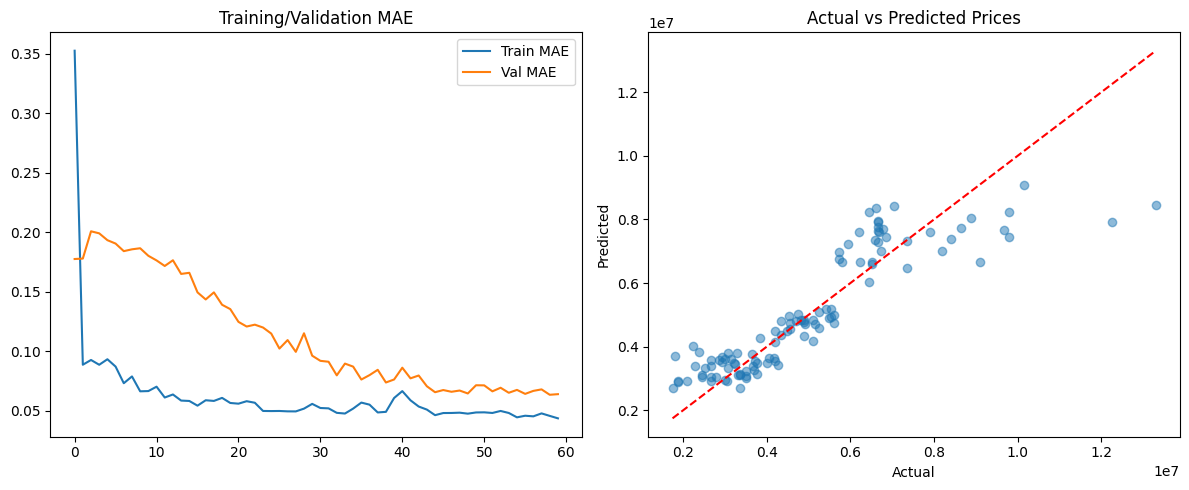

In [14]:
# 1. Make Predictions and Inverse Scale them
predictions_scaled = model.predict([testX_tab, testX_img])
predictions = scaler_y.inverse_transform(predictions_scaled)
actual = scaler_y.inverse_transform(testY)

# 2. Calculate Metrics
mae = mean_absolute_error(actual, predictions)
rmse = np.sqrt(mean_squared_error(actual, predictions))

print(f"\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")

# 3. Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training/Validation MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(actual, predictions, alpha=0.5)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

Graph saved as 'multimodal_results_roxi.png'


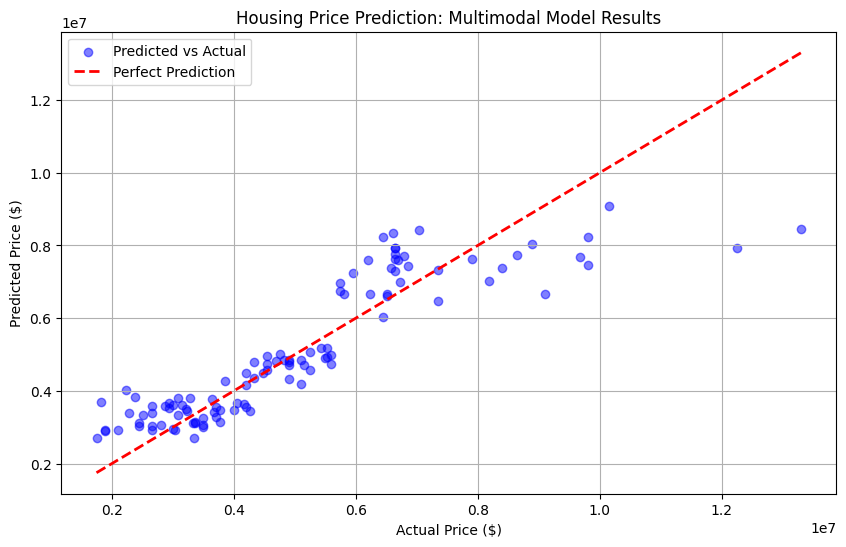

In [15]:
# Save the performance visualization to a file
plt.figure(figsize=(10, 6))
plt.scatter(actual, predictions, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Housing Price Prediction: Multimodal Model Results')
plt.legend()
plt.grid(True)

# Save as PNG
plt.savefig('multimodal_results_roxi.png')
print("Graph saved as 'multimodal_results_roxi.png'")
plt.show()